In [ ]:
####################
##Weighted Average##
####################

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Movies = pd.read_csv('movies.csv')
Ratings = pd.read_csv('ratings.csv')

rating_matrix = Ratings.pivot_table(values='rating',columns='movieId',index='userId')

## Adding another column WA to Movies
Overall_ratings = []
Overall_votes = []
for i in range(len(rating_matrix.columns)):
    Movie_votes = (len(rating_matrix.index) - np.isnan(np.array(rating_matrix.iloc[:,i])).sum())
    Overall_votes.append(Movie_votes)
    Movie_rates = rating_matrix.iloc[:,i].sum()/Movie_votes
    Overall_ratings.append(Movie_rates)

droped = []
for i in range(len(Movies.index)):
    if Movies.iloc[i,0] not in rating_matrix.columns:
        #print(Movies.iloc[i,0])
        droped.append(i)
        #print('-------------------')
        #print(rating_matrix.columns[i])

Movies = Movies.drop(index=droped)
Movies = Movies.reset_index()

Movies['ratings'] = Overall_ratings
Movies['votes'] = Overall_votes

v=Movies['votes']
R=Movies['ratings']
C=Movies['ratings'].mean()
m=Movies['votes'].quantile(0.70)
Movies['weighted_average']=((R*v)+ (C*m))/(v+m)
Movies_sorted = Movies.sort_values('weighted_average', ascending=False)


##Devide into train_set and test_set (70% train)
train_ratings = pd.DataFrame()
test_ratings = pd.DataFrame()

for i in range(610):
  user_i = Ratings[Ratings['userId'] == i+1]
  user_i = shuffle(user_i)
  #print(user_i)
  #print(user_i.iloc[0:int(len(user_i.index)*0.7),:])
  train_ratings = train_ratings.append(user_i.iloc[0:int(len(user_i.index)*0.7),:])
  #print(train_ratings)
  #reak
  test_ratings = test_ratings.append(user_i.iloc[int(len(user_i.index)*0.7):,:])

##Working on the training set
rating_matrix = train_ratings.pivot_table(values='rating',columns='movieId',index='userId')


In [ ]:
################################
##Content-Based Recommendation##
################################


#Oscars dataset, IF-IDF technique for Movie Info:
oscars= pd.read_csv("oscars.csv", encoding='latin-1')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
tfidf = TfidfVectorizer(stop_words='english')
oscars['Movie Info'] = oscars['Movie Info'].fillna('')
tfidf_matrix = tfidf.fit_transform(oscars['Movie Info'])
tfidf_matrix.shape
cosine_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(oscars.index, index=oscars['Film']).drop_duplicates()

## Content-based method based on movie infomation
def get_recommendations_info(title, cosine_similarity=cosine_similarity):
    index = indices[title]
    similarity_scores = list(enumerate(cosine_similarity[index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:11]
    movie_indices = [i[0] for i in similarity_scores]
    return oscars['Film'].iloc[movie_indices]

In [ ]:
get_recommendations_info('The Godfather')

290     The Godfather Part II
373    The Godfather Part III
145          The Lost Weekend
154              The Yearling
558              The Irishman
224            The Sundowners
359                Moonstruck
468            The Blind Side
49                Alice Adams
547                Green Book
Name: Film, dtype: object

In [ ]:
get_recommendations_info('The Lord of the Rings: The Return of the King')

434                The Lord of the Rings: The Two Towers
429    The Lord of the Rings: The Fellowship of the Ring
116                                   The Maltese Falcon
81                          The Adventures of Robin Hood
180                           The Greatest Show on Earth
213                                     The Defiant Ones
553                                       A Star Is Born
54                          The Lives of a Bengal Lancer
372                                                Ghost
396                                            Apollo 13
Name: Film, dtype: object

In [ ]:
# We apply the same technique to movies dataset from MovieLens based on genre:

films=Movies
films['genres'] = films['genres'].fillna('')
tfidf_matrix2 = tfidf.fit_transform(films['genres'])
tfidf_matrix2.shape
cosine_similarity = linear_kernel(tfidf_matrix2, tfidf_matrix2)
indices = pd.Series(films.index, index=films['title']).drop_duplicates()

## Content-based method based on Genres
def get_recommendations_genre(title, cosine_similarity=cosine_similarity):
    index = indices[title]
    similarity_scores = list(enumerate(cosine_similarity[index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:11]
    movie_indices = [i[0] for i in similarity_scores]
    return films['title'].iloc[movie_indices]


In [ ]:
get_recommendations_genre('Toy Story (1995)')

1705                                          Antz (1998)
2353                                   Toy Story 2 (1999)
2805       Adventures of Rocky and Bullwinkle, The (2000)
2996                     Emperor's New Groove, The (2000)
3563                                Monsters, Inc. (2001)
6177                                     Wild, The (2006)
6469                               Shrek the Third (2007)
6931                       Tale of Despereaux, The (2008)
7742    Asterix and the Vikings (Astérix et les Viking...
8201                                         Turbo (2013)
Name: title, dtype: object

In [ ]:
get_recommendations_genre('Jurassic World: Fallen Kingdom (2018)')

5652               Sound of Thunder, A (2005)
6313                   Children of Men (2006)
6664                            Jumper (2008)
7749                  The Hunger Games (2012)
8572                    Jurassic World (2015)
9689    Jurassic World: Fallen Kingdom (2018)
418                      Jurassic Park (1993)
615      Independence Day (a.k.a. ID4) (1996)
656                   Escape from L.A. (1996)
855                         Abyss, The (1989)
Name: title, dtype: object

In [ ]:
################################
##Item-Based CF Recommendation##  ##Based on Genres##
################################
import datetime
#Derive all genres of movies
def sep(series):
    Full = []
    for i in range(len(series)):
        #print(i)
        #print(Full)
        if '|' in series[i]:
            for genre in series[i].split('|'):
                if genre not in Full:
                    Full.append(genre)
        else:
            if series[i] not in Full:
                Full.append(series[i])
    return Full

All_genres = sep(Movies['genres'])
Cleaned_Movies = Movies.drop(index = Movies[Movies['genres'] == '(no genres listed)'].index).reset_index()
All_genres = sep(Cleaned_Movies['genres'])

#transformation into a Genres_df
data = []
for i in range(len(Cleaned_Movies['genres'])):
    row = [Cleaned_Movies.iloc[i,2],Cleaned_Movies.iloc[i,3]]
    for genre in All_genres:
        if genre in Cleaned_Movies['genres'][i]:
            row.append(1)
        else:
            row.append(0)
    data.append(row)
column = ['MovieId']+['title']+All_genres

Genres_df = pd.DataFrame(data,columns = column)

Genres_df['WA']  =Movies['weighted_average']


##Build the recommendation on a movie
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

def takeSecond(elem):
    return elem[1]

def predict_similar_movie(movie_name):
  sparse_Genres = csr_matrix(Genres_df.iloc[:,2:]) #Create a Sparse Matrix
  similarity_score = []
  target_indice = Genres_df[Genres_df['title']==movie_name].index.values[0]
  for i in range(sparse_Genres.shape[0]):
    similarity_score.append((Genres_df.iloc[i,0],cosine_similarity(sparse_Genres[target_indice],sparse_Genres[i])[0][0]))
  similarity_score.sort(key = takeSecond,reverse=True)
  return similarity_score[1:51]

def item_Elbow_Method(df):
    #choosing the best k via Elbow Method
    SSE = []
    for k in range(2,50):
        estimator = KMeans(n_clusters = k,random_state=0)
        estimator.fit(df)
        SSE.append(estimator.inertia_)
    X = range(2,50)
    plt.xlabel('k-values')
    plt.ylabel('SSE')
    plt.plot(X,SSE,'o-')
    plt.show()

def Modified_predict_similar_movie(movie_name,optimized_k):
    clustering = KMeans(n_clusters = optimized_k,random_state=0)

    clusters = clustering.fit_predict(Genres_df.iloc[:,2:])
    Genres_df['Label'] = clusters


    label = np.array(Genres_df[Genres_df['title'] == movie_name])[0][-1]

    Movies_within_Cluster = Genres_df[Genres_df['Label']==label]
    Movies_within_Cluster_reset_index = Movies_within_Cluster.reset_index()

    target_indice = Movies_within_Cluster_reset_index[Movies_within_Cluster_reset_index['title'] == movie_name].index.values[0]
    #print(target_indice)
    ids = Movies_within_Cluster.index
    #print(ids)
    Sparse_Movies_within_Cluster = csr_matrix(Movies_within_Cluster.iloc[:,2:-1])
    #print(Sparse_Movies_within_Cluster)

    ##Select top 2 similar users based on Cosine Similarity

    similarity_score = []

    for i in range(Sparse_Movies_within_Cluster.shape[0]):
        similarity_score.append((Genres_df.iloc[ids[i],0],cosine_similarity(Sparse_Movies_within_Cluster[target_indice],Sparse_Movies_within_Cluster[i])[0][0]))
    similarity_score.sort(key = takeSecond,reverse=True)


    #print (similarity_score)
    return similarity_score[1:51]


def item_based_recommend_movie(user,Method):
    history_movieId = list(train_ratings[train_ratings['userId']==user]['movieId'].values)

    #Modified_movieId = Movies[Movies['movieId'].isin(history_movieId)].sort_values(by='weighted_average',ascending=False)

    #Modified_movieId = np.array(Modified_movieId.iloc[0:3,1])

    result = []
    test_Idset = np.array(test_ratings[test_ratings["userId"]==user]['movieId'])


    for movieIds in history_movieId:
        #print(type(Cleaned_Movies[Cleaned_Movies['movieId']==movieIds]['title'][0]))
        if Method == 'Normal':
            similars = predict_similar_movie(Cleaned_Movies[Cleaned_Movies['movieId']==movieIds]['title'].values[0])
            for movie in similars:
                #print(movie)
                if (movie[0] not in result) and (movie[0] not in history_movieId):
                    result.append(movie[0])
        if Method == 'Modified':
            similars = Modified_predict_similar_movie(Cleaned_Movies[Cleaned_Movies['movieId']==movieIds]['title'].values[0], 13)
            for movie in similars:
                if (movie[0] not in result) and (movie[0] not in history_movieId):
                    result.append(movie[0])

    print("The recommendated Movies for the user with userId " + str(user) + " are ")
    n=0
    print(result)
    for movieId in result:
        if movieId in test_Idset:
          n+=1
          print("The movie "+ Cleaned_Movies[Cleaned_Movies['movieId']==movieId]['title'].values[0]+" is succesfully predicted")
        print(Cleaned_Movies[Cleaned_Movies['movieId']==movieId]['title'].values[0])

    Precision = 1.0*n/len(result)
    print("The precision of this method is " + str(Precision))

    return result

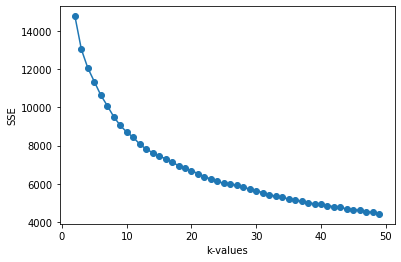

In [ ]:
item_Elbow_Method(Genres_df.iloc[:,2:])
#we choose k = 13

In [ ]:
import datetime
print("The result for item-based method without clustering: ")
start_1 = datetime.datetime.now()

modified_result = item_based_recommend_movie(2,'Normal')

end_1 = datetime.datetime.now()
print("---------------------------------------------------------------------------------------------------------------")
print("The result for item-based method with clustering: ")

start_2 = datetime.datetime.now()

modified_result = item_based_recommend_movie(2,'Modified')

end_2 = datetime.datetime.now()

print("The running time without clustering is ")
print (end_1 - start_1)
print("The running time with clustering is ")
print (end_2 - start_2)



The result for item-based method without clustering: 
The recommendated Movies for the user with userId 2 are 
[111, 7981, 4034, 55118, 55765, 3741, 2268, 1344, 4776, 44199, 2203, 2912, 27831, 2391, 1729, 51540, 2176, 53129, 5294, 3298, 96811, 6187, 5867, 7587, 7018, 6552, 68159, 7333, 6086, 4326, 84392, 482, 4450, 456, 2952, 6335, 26585, 162606, 26612, 26704, 74948, 4052, 162828, 55391, 3551, 3056, 8456, 26231, 32179, 553, 1209, 3681, 54997, 1304, 8132, 2951, 1283, 56782, 1266, 3365, 104913, 115216, 3871, 6461, 32387, 109968, 4180, 26401, 4448, 3020, 3093, 3467, 8937, 5786, 7218, 72554, 3404, 3737, 4785, 5240, 65631, 77893, 107159, 7894, 6577, 26865, 49651, 3107, 1928, 4710, 41627, 86815, 90243, 111844, 1465, 61289, 522, 3029, 7027, 33794, 136020, 97950, 81834, 89745, 2692, 3030, 93838, 1291, 115727, 7482, 68358, 115151, 3384, 1198, 62849, 6378, 4444, 8636, 7925, 8142, 5244, 147662, 150401, 96079, 5574, 86628, 1049, 284, 32511, 91485, 6664, 160563, 85354, 112897, 32632, 73499, 107846,

In [ ]:
test_ratings[test_ratings['userId']==2]

,userId,movieId,rating,timestamp
235,2,3578,4.0,1445714885
252,2,91658,2.5,1445714938
233,2,333,4.0,1445715029
241,2,60756,5.0,1445714980
245,2,77455,3.0,1445714941
234,2,1704,4.5,1445715228
255,2,109487,3.0,1445715145
236,2,6874,4.0,1445714952
238,2,46970,4.0,1445715013


In [ ]:
################################
##User-Based CF Recommendation##
################################
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def predict_similar_user(user):
    sparse_ratings = csr_matrix(rating_matrix.fillna(0))
    #userID ranges from 1 to 610
    similarity_score = []
    cosine_compute_times = 0
    for i in range(sparse_ratings.shape[0]):
        similarity_score.append((i,cosine_similarity(sparse_ratings[user],sparse_ratings[i])[0][0]))
        cosine_compute_times += 1

    similarity_score.sort(key = takeSecond,reverse=True)
    print("Computed the cosine similarity score for " + str(cosine_compute_times) + " times.")
    return similarity_score[1:11]

def Modified_predict_similar_user(user,optimized_k):
    Users_df = rating_matrix.fillna(0)
    start = datetime.datetime.now()
    clustering = KMeans(n_clusters = optimized_k, random_state = 0)
    clusters = clustering.fit_predict(Users_df)
    end = datetime.datetime.now()
    #print(clusters)
    print("The running time for clustering is " + str(end-start))

    Users_df['Label'] = clusters

    label = Users_df.iloc[user,-1]
    #print(label)

    Users_within_Cluster = Users_df[Users_df['Label']==label]

    #print(Users_within_Cluster)

    ids = Users_within_Cluster.index

    Sparse_Users_within_Cluster = csr_matrix(Users_within_Cluster)

    ##Select top 10 similar users based on Cosine Similarity

    similarity_score = []
    cosine_compute_times = 0
    for i in range(Sparse_Users_within_Cluster.shape[0]):

        score = cosine_similarity(Sparse_Users_within_Cluster[user], Sparse_Users_within_Cluster[i])[0][0]

        similarity_score.append((ids[i],score))
        cosine_compute_times += 1

    similarity_score.sort(key = takeSecond, reverse = True)
    print("Computed the cosine similarity score for " + str(cosine_compute_times) + " times.")
    return similarity_score[1:11]

def user_based_recommend_movie(user,similar_users):
    #exceptedmovies = rating_matrix.iloc[user,:].dropna().index.values
    #listofmovies = []
    #for similars in similar_users:
        #if similars[0] == user: continue
        #else:
            #whole_rating_matrix = Ratings.pivot_table(values='rating',columns='movieId',index='userId')
            #for movieid in whole_rating_matrix.iloc[similars[0],:].dropna().index.values:
                #if movieid not in exceptedmovies:
                    #if (movieid,np.array(Movies[Movies['movieId']==movieid])[0][-1]) not in listofmovies:
                        #listofmovies.append((movieid,np.array(Movies[Movies['movieId']==movieid])[0][-1]))

    #listofmovies.sort(key = takeSecond,reverse=True)
    #listofmovies = listofmovies[0:21]
    User_history_movies = rating_matrix.iloc[user,:].dropna().index.values
    moviesId = []

    for similar_user in similar_users:
        similar_user_history_movies = np.array(Ratings[Ratings["userId"]==similar_user[0]]["movieId"])
        for movie in similar_user_history_movies:
            if movie not in User_history_movies and movie not in moviesId:
                moviesId.append(movie)


    test_Idset = np.array(test_ratings[test_ratings["userId"]==user]['movieId'])
    movie_names = []
    n = 0

    print("The recommendated movies for user with userId " + str(user) + " are : ")
    for ids in moviesId:
        movie_name = Movies[Movies['movieId']==ids]['title'].values[0]
        print(movie_name)
        movie_names.append(movie_name)
        if ids in test_Idset:
          n+=1
    Precision = 1.0*n/len(moviesId)

    print("The precision of this method is " + str(Precision))

    return movie_names

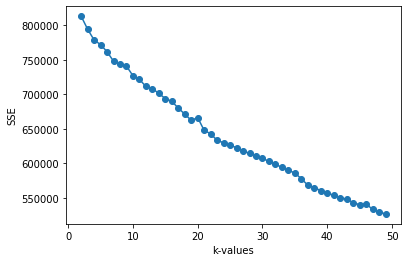

In [ ]:
item_Elbow_Method(rating_matrix.fillna(0))
## we choose k = 8

In [ ]:
import datetime

print("The result for user-based method without clustering: ")

start_1 = datetime.datetime.now()
normal_similar = predict_similar_user(1)
normal_result = user_based_recommend_movie(1,normal_similar)
end_1 = datetime.datetime.now()

print("---------------------------------------------------------------------------------------")
print("The result for user-based method with clustering: ")

start_2 = datetime.datetime.now()
modified_similar = Modified_predict_similar_user(1,8)
modified_result = user_based_recommend_movie(1,modified_similar)
end_2 = datetime.datetime.now()

print("The running time without clustering is ")
print(end_1-start_1)
print("The running time with clustering is ")
print(end_2-start_2)

The result for user-based method without clustering: 
Computed the cosine similarity score for 610 times.
The recommendated movies for user with userId 1 are : 
Toy Story (1995)
American President, The (1995)
Casino (1995)
Copycat (1995)
Babe (1995)
Mortal Kombat (1995)
Seven (a.k.a. Se7en) (1995)
Mr. Holland's Opus (1995)
Apollo 13 (1995)
Crimson Tide (1995)
Crumb (1994)
Net, The (1995)
Star Wars: Episode IV - A New Hope (1977)
Little Women (1994)
Pulp Fiction (1994)
While You Were Sleeping (1995)
Forrest Gump (1994)
Lion King, The (1994)
Dave (1993)
Fugitive, The (1993)
In the Line of Fire (1993)
Jurassic Park (1993)
Home Alone (1990)
Aladdin (1992)
Terminator 2: Judgment Day (1991)
Batman (1989)
Silence of the Lambs, The (1991)
Beauty and the Beast (1991)
Pinocchio (1940)
Pretty Woman (1990)
Fargo (1996)
Mission: Impossible (1996)
Trainspotting (1996)
Kingpin (1996)
Wizard of Oz, The (1939)
Cinderella (1950)
Die Hard (1988)
Fish Called Wanda, A (1988)
Reservoir Dogs (1992)
Platoon (